<h1><b><i> Study of kickstarter data with three models </i></b></h1>
<h2>Author: Yanzhi Meng</h2>

__Motivation: This project is to study the data of the kickstarter projects, tryint to help upcoming entrepreneurs make better plans on kickstarter to improve their rates of success.__

> Kickstarter is an American public-benefit corporation based in Brooklyn, New York, that maintains a global crowdfunding platform focused on creativity and merchandising.

<div style="text-align: right">wikipedia</div>
</br>

The popose of this study is trying to learn how the features of the entrepreneurial projects 
determine their fate. Each creative project falls into a category which with others make a main category. Projects can be lauched from different countries at different times. When a project is launched, the owner needs to set a goal of pledge. Currencies of the launching countries are used to measure the pleged value of the projects. After projects are launched, during a pre-set period, a project gets pleged money from online users. If a project gets more pleged money than its goal before the deadline of the project period, then its fate is successful; if it desn't get pledge less than the goal, its state is failed. Some of the projects are closed before the deadline with no stated reason, then its state is canceled. Besides the above three states, the projects' states can be undefined (no stated criteria), suspensed (no stated criteria), and live, which means the pojects' deadlines have not yet arrived.


The projects that end up with states to be ``undefine``, ``suspensed``, ``live`` are much less than data that end up with ``successful``, ``failed``, and ``canceled``. In our study, these data are ignored. We focus on the three major states. Our porblem is a classification problem with three classes.

For convience of the study, we convert all currencies to American dollars. We consider the launching time of a project is a nontrivial factor to determine its final rate. We separate a day into 4 sections into which a project's launching time falls. In addition, we consider the preset life of a project plays a role in determining its fate as well. We set the number of days between the launching time and its deadline of a project's life on kickstarter. Fianlly there are 5 factors to determine a project's fate:
    <ol>
        <li>``category`` -- the category of the project belongs to (including poety, music, ect)</li>
        <li>``country`` -- the country where the project is launched</li>
        <li>``goal`` -- the preset value of the project</li>
        <li>``time`` -- the lauching time of the project (including 0am - 6am, 6am - 12pm, 12pm - 6pm, 6pm -- 12am)</li>
        <li>``days`` -- the life of the project on kickstarter in days</li>
    </ol>
    
We randomly divide the data into ``train`` (40%), ``validation`` (20%), and ``test`` (40%). We run three models on the data sets: random forest, KNN, and Neural network. We compared the efficiencies of the three models on the same data sets. They give similar accuracies. Closer comparisons find KNN gives the best result. This is surprising. Although deep learning models do good jobs in many fields, due to the nature of the current problem, which is of independent individuals of online users. No obvious numerical correlation exists among them. As much as similarty a project is with past projects tells the fate of the project.

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
from sklearn import preprocessing 

In [2]:
# read in data

projects = pd.read_csv('ks-projects-201801.csv')
# df = pd.read_csv('ks-projects-201801.csv')

In [3]:
projects.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


# data analysis:
 - cleaning
 - encoding
 - visualization
 

In [4]:
projects['state'].unique()

array(['failed', 'canceled', 'successful', 'live', 'undefined',
       'suspended'], dtype=object)

In [5]:
print(f'dataset has {projects.shape[0]} rows and {projects.shape[1]} columns.')

dataset has 378661 rows and 15 columns.


In [6]:

# the 3 most significant values of state are failed, successful, canceled.
# others far less significant
# --targets of the classification problem.

projects.groupby(['state']).count()[['ID']].sort_values('ID', ascending=False)

,ID
state,
failed,197719
successful,133956
canceled,38779
undefined,3562
live,2799
suspended,1846


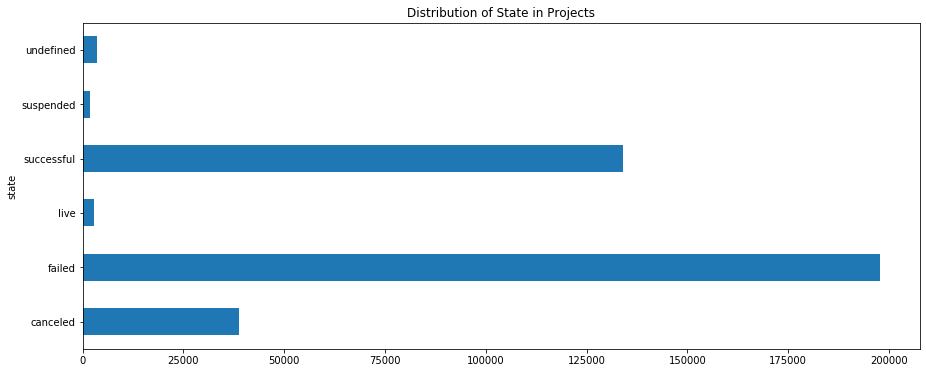

In [7]:
projects.groupby('state').count()[['ID']].plot(kind='barh',
          title='Distribution of State in Projects',
          figsize=(15, 6), legend=None)
plt.show()

In [8]:
# classification with 3 classes.

target_classes = ['failed', 'successful', 'canceled']

In [9]:
# how projects of each country behave.

countryCountSuccessful = {country: projects['country'][(projects['country'] == country) & \
                                          (projects['state'] == 'successful')].count() \
                      for country in projects['country'].unique()}
countryCountFailed = {country: projects['country'][(projects['country'] == country) & \
                                          (projects['state'] == 'failed')].count() \
                      for country in projects['country'].unique()}
countryCountCanceled = {country: projects['country'][(projects['country'] == country) & \
                                          (projects['state'] == 'canceled')].count() \
                      for country in projects['country'].unique()}

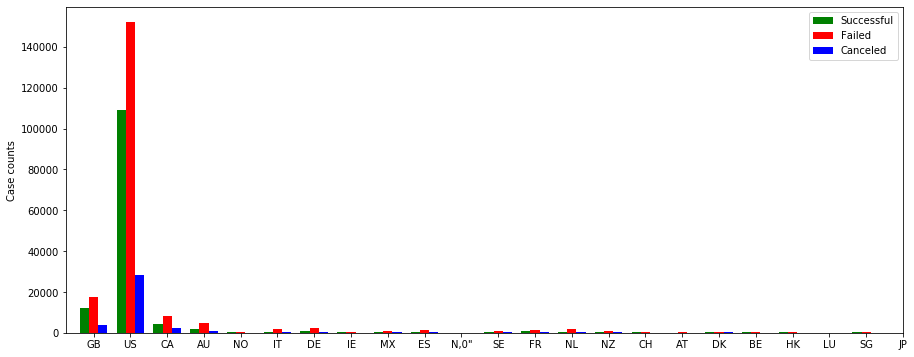

In [10]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)


## necessary variables
N = len(countryCountSuccessful)
ind = 2*np.arange(N)                # the x locations for the groups
width = 0.5                      # the width of the bars

## the bars
rects1 = ax.bar(ind + width, list(countryCountSuccessful.values()), width,
                color='green')

rects2 = ax.bar(ind + 2 * width, list(countryCountFailed.values()), width,
                    color='red')

rects3 = ax.bar(ind + 3 * width, list(countryCountCanceled.values()), width,
                    color='blue')

# axes and labels
ax.set_xlim(-width,len(ind)+2*width)
ax.set_ylabel('Case counts')

xTickMarks = [list(countryCountSuccessful.keys())[i] for i in range(N)]
ax.set_xticks(ind+2*width)
xtickNames = ax.set_xticklabels(xTickMarks)

## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Successful', 'Failed', 'Canceled') )

plt.show()

In [11]:
# convert currencies to USD

def currency_converter(currency):
    switcher = {
        'GBP': 1.0/0.76,
        'USD': 1.0/1.0,
        'CAD': 1.0/1.33,
        'AUD': 1.0/1.42,
        'NOK': 1.0/9.05,
        'EUR': 1.0/0.9,
        'MXN': 1.0/19.17,
        'SEK': 1.0/9.56,
        'NZD': 1.0/1.55,
        'CHF': 1.0/0.98,
        'DKK': 1.0/6.70,
        'HKD': 1.0/7.78,
        'SGD': 1.0/1.35,
        'JPY': 1.0/111.33
    }
    return switcher.get(currency, "nothing")

In [12]:
# convert currencies in ['goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']
# to us dollars

for money in ['goal', 'pledged', 'usd pledged', 'usd_pledged_real', 'usd_goal_real']:
    projects[money] = projects[money] * projects['currency'].apply(currency_converter)
# projects.head()

In [13]:
# encode some of the columns of string values. 
# we manual encode state, because it's values need to be aligned mandatory network output

def StateEncoder(state):
    if state == 'successful':
        return 0
    elif state == 'failed':
        return 1
    elif state == 'canceled':
        return 2
    else:
        return 3

projects.state = projects.state.apply(StateEncoder)
projects = projects[~(projects.state == 3)]

encoded_columns = [
 'name',
 'category',
 'main_category',
 'goal',
 'country']
for col in encoded_columns:
    le = preprocessing.LabelEncoder()
    le.fit(list(projects[col].astype(str).values))
    projects[col] = le.transform(list(projects[col].astype(str).values))


In [14]:
# we don't assume every hour of project launching may matters. but we separate a day into 4 
# sections:
# {
# 0am - 6am:  1
# 6am - 12pm: 2
# 12pm - 6pm: 3
# 6pm - 12am: 4
# }
# effect of project lauching time varies with reference to sections

projects['launch_hour'] = pd.to_datetime(projects['launched']).dt.hour

def time_section(time):
    if 0 <= time and time < 6:
        return 1    # early morning
    elif 6 <= time and time < 12:
        return 2    # late morning
    elif 12 <= time and time < 18:
        return 3    # afternoon
    else:
        return 4    # night
    
projects['launch_hour'] = projects['launch_hour'].apply(time_section)
# projects['launch_hour']

In [15]:
# the length of the project on kickstarter may change the fate the projects.
# we count the days between the deadline and the launching date
# projects['period'] =  - pd.to_datetime(projects['launched']).dt.date()

life = pd.to_datetime(projects['deadline']) - pd.to_datetime(projects['launched'])
projects['days'] = life.dt.days
# projects.head()

In [16]:
## how project states depend on launch hour

sectionCountSuccessful \
= {section: projects['launch_hour'][(projects['launch_hour'] == section) & \
                                          (projects['state'] == 0)].count() \
                      for section in projects['launch_hour'].unique()}

sectionCountFailed \
= {section: projects['launch_hour'][(projects['launch_hour'] == section) & \
                                          (projects['state'] == 1)].count() \
                      for section in projects['launch_hour'].unique()}

sectionCountCanceled \
= {section: projects['launch_hour'][(projects['launch_hour'] == section) & \
                                          (projects['state'] == 2)].count() \
                      for section in projects['launch_hour'].unique()}

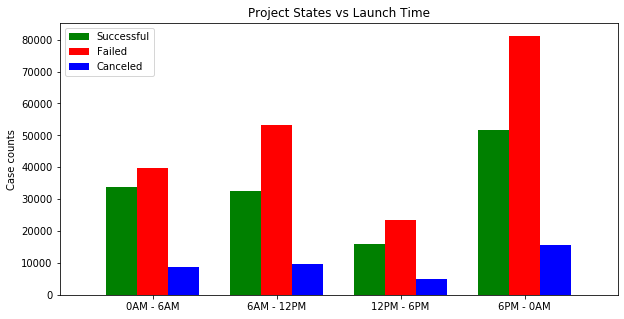

In [17]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)


## necessary variables
N = 4
ind = 2*np.arange(N)                # the x locations for the groups
width = 0.5                           # the width of the bars

## the bars
rects1 = ax.bar(ind + width, sectionCountSuccessful.values(), width,
                color='green')

rects2 = ax.bar(ind + 2 * width, sectionCountFailed.values(), width,
                    color='red')

rects3 = ax.bar(ind + 3 * width, sectionCountCanceled.values(), width,
                    color='blue')

# axes and labels
ax.set_xlim(-width, 2*len(ind)+width)
ax.set_ylabel('Case counts')

xTickMarks = ['0AM - 6AM', '6AM - 12PM', '12PM - 6PM', '6PM - 0AM']
ax.set_xticks(ind+2*width)
xtickNames = ax.set_xticklabels(xTickMarks)

## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0]), ('Successful', 'Failed', 'Canceled') )

plt.title('Project States vs Launch Time')
plt.show()

In [18]:
print(f"the shortest projects are {np.min(projects['days'])} days and the longest\
 projects are {np.max(projects['days'])} days long.")

# super old projects are treated as outliers

projects['days'].sort_values(ascending=False).head(20)

the shortest projects are 0 days and the longest projects are 14866 days long.


2842      14866
48147     14834
94579     14760
75397     14749
247913    14732
273779    14708
305126       91
226361       91
226191       91
88090        91
170950       91
38476        91
150277       91
98785        91
206611       91
153557       91
151836       91
61014        91
74196        91
173919       91
Name: days, dtype: int64

In [19]:
projects = projects[projects['days'] < 100]

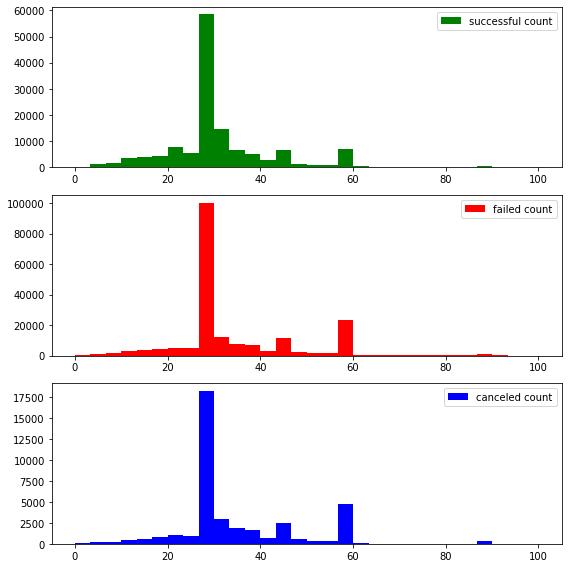

In [20]:
# how project states depend on the life of the projects


# x = np.arange(0, 100)
fig, axs = plt.subplots(3, 1, tight_layout=True, figsize=(8, 8))
n_bins = 30

axs[0].hist(projects[projects['state'] == 0]['days'], \
            bins=n_bins, range=[0, 100], color="green")
axs[1].hist(projects[projects['state'] == 1]['days'], \
            bins=n_bins, range=[0, 100], color="red")
axs[2].hist(projects[projects['state'] == 2]['days'], \
            bins=n_bins, range=[0, 100], color="blue")

axs[0].legend(['successful count'])
axs[1].legend(['failed count'])
axs[2].legend(['canceled count'])

fig.tight_layout()
plt.show()

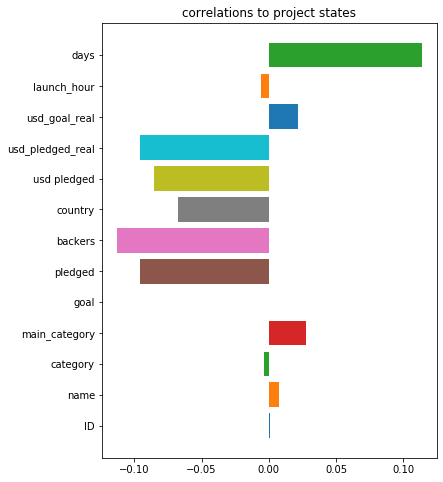

In [21]:
# correlation coefficents of numberical columns with 'state'

state_corr = {attr: projects['state'].corr(projects[attr]) for attr in \
              ['ID', 'name', 'category', 'main_category', 
       'goal', 'pledged', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real', 'launch_hour',
       'days']}

N = range(len(state_corr))
## the bar presentation of correlation to projects['state']

fig, ax = plt.subplots(figsize=(6, 8))
for attr in state_corr:
    plt.barh(y = attr, width = state_corr[attr])
    
plt.title('correlations to project states')
plt.show()

In [22]:
# some of the factors are not independent, for example main_categroy and category. 
# some factors are derivative, rather determining factors, such as usd_pledged, usd_pledged_real.
# we extract factors that are independent and relatively significant. 

factors = ['category', 
           'goal', 
           'country',  
           'launch_hour',
           'days']
# we try to learn how the relevant factors determine projects['state']. 
target = ['state']

X = projects[factors]
y = projects[target]

# model building
- KNN
- random forest
- support vector machine
- neural network

In [23]:
# choose train, valid, and test data sets. 
# 40% train, 20% validation, 40% test

x = np.random.rand(len(X))
train = x < .4
valid = (x >= .4) & (x < 0.6)
test = x >= 0.6

X_train = X[train]
X_valid = X[valid]
X_test = X[test]

y_train = np.array(y[train])
y_valid = np.array(y[valid])
y_test = np.array(y[test])


# KNN

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# define a function to calculate the accuracy of the model to valid data and test data 
# with parameter K 

def knn_acc(paraRange, x_tr, x_va, x_te, y_tr, y_va, y_te):
    acc = []
    for n_neighb in paraRange:
        knn = KNeighborsClassifier(n_neighbors = n_neighb, p = 2, metric = 'minkowski')
        knn.fit(x_tr, y_tr.ravel())
        va_preds = knn.predict(x_va)
        te_preds = knn.predict(x_te)
        tr_preds = knn.predict(x_tr)
        va_score = accuracy_score(va_preds, y_va)
        te_score = accuracy_score(te_preds, y_te)
        tr_score = accuracy_score(tr_preds, y_tr)
        acc.append([va_score, te_score, tr_score])
    return acc

accuracy_list = knn_acc(range(3, 11), X_train, X_valid, X_test, y_train, y_valid, y_test)

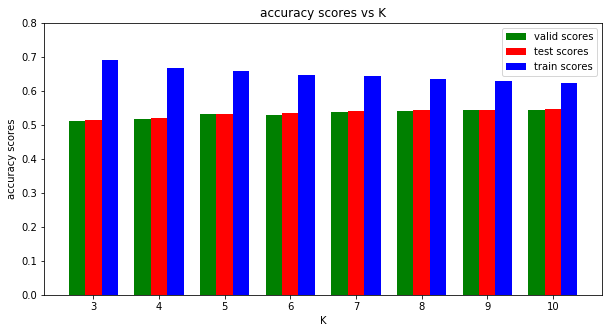

In [25]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)


## necessary variables
N = len(accuracy_list)
ind = 2*np.arange(N)                # the x locations for the groups
width = 0.5                           # the width of the bars

## the bars
for i in range(N):
    rects1 = ax.bar(2 * i + width, accuracy_list[i][0], width,
                    color='green')
    rects2 = ax.bar(2 * i + 2 * width, accuracy_list[i][1], width,
                        color='red')
    rects3 = ax.bar(2 * i + 3 * width, accuracy_list[i][2], width,
                        color='blue')

# axes and labels
ax.set_xlim(-width, 2 * N + width)
ax.set_ylim(0, .8)
ax.set_xlabel('K')
ax.set_ylabel('accuracy scores')

xTickMarks = list(range(3, 11))
ax.set_xticks(ind + 2 * width)
xtickNames = ax.set_xticklabels(xTickMarks)

## add a legend
ax.legend( (rects1[0], rects2[0], rects3[0]), ('valid scores', 'test scores', 'train scores') )

plt.title('accuracy scores vs K')
plt.show()

In [26]:
knn_acc(range(10, 11), X_train, X_valid, X_test, y_train, y_valid, y_test)

[[0.5452784503631961, 0.5467661422329243, 0.6245531679548919]]

# random forest

In [27]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion = 'gini', max_depth = 4, random_state = 1)
tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1, splitter='best')

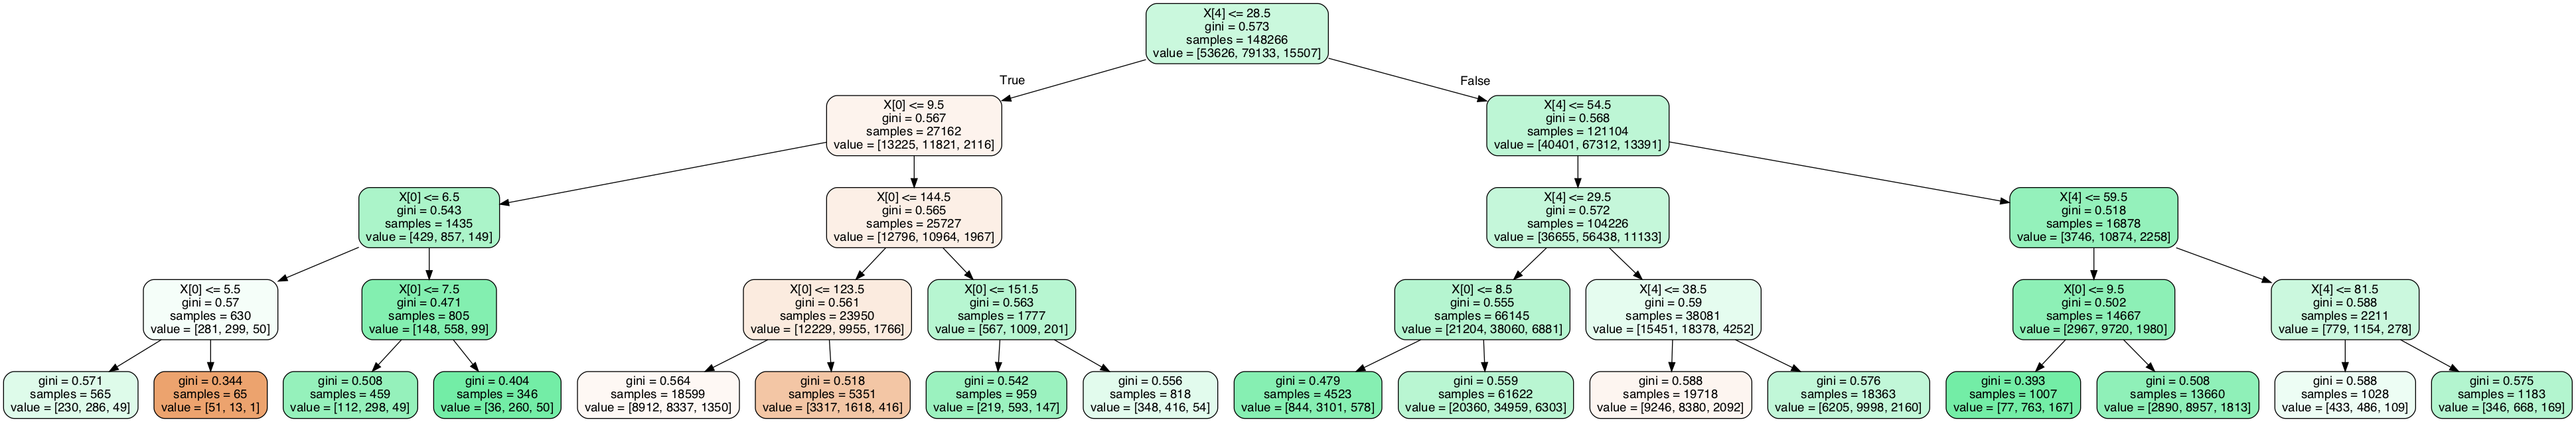

In [28]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz
from IPython.display import Image

dot_data = export_graphviz(tree, filled=True, rounded=True)
graph = graph_from_dot_data(dot_data)
graph.write_png('tree-vis.png')
Image("tree-vis.png")

In [29]:
valid_preds_tree = tree.predict(X_valid)
test_preds_tree = tree.predict(X_test)
train_preds_tree = tree.predict(X_train)
valid_score_tree = accuracy_score(valid_preds_tree, y_valid)
test_score_tree = accuracy_score(test_preds_tree, y_test)
train_score_tree = accuracy_score(train_preds_tree, y_train)

In [30]:
print(f'accuracy score of valid data is {valid_score_tree}.\n \n \
accuracy score of test data is {test_score_tree}.\n \n \
accuracy score of train data is {train_score_tree}.')

accuracy score of valid data is 0.5563223029324724.
 
 accuracy score of test data is 0.5555796052542579.
 
 accuracy score of train data is 0.5551576221116102.


# support vector machine

In [31]:
from sklearn.svm import SVC

svc = SVC(kernel='linear')
# svc.fit(X_train[['launch_hour', 'days']], y_train.ravel())

# neural network

In [32]:
# import pytorch

import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

In [33]:
# construct the linear network
# we have only one hidden layer, for simplicity

num_features = X_train.shape[1]   #  = 5
num_hidden = 10                   #  arbitraily chosen
num_classes = 3                   # successful, failed, canceled

class Net(nn.Module):

    def __init__(self, num_i, num_h, num_f):
        super(Net, self).__init__() 
        self.W_1 = Parameter(init.kaiming_normal_(torch.Tensor(num_h, num_i)))
        self.b_1 = Parameter(init.constant_(torch.Tensor(num_h), 0))
        
        # hidden layer
        self.W_2 = Parameter(init.kaiming_normal_(torch.Tensor(num_f, num_h)))
        self.b_2 = Parameter(init.constant_(torch.Tensor(num_f), 0))
        
        # define activation function in constructor
        self.activation = torch.nn.ELU()

    def forward(self, x):
        x = F.linear(x, self.W_1, self.b_1)
        x = self.activation(x)
        x = F.linear(x, self.W_2, self.b_2)
        return x


net = Net(num_features, num_hidden, num_classes)

In [34]:
# optimizer and lose function

optimizer = optim.SGD(net.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

Epoch  1 : Train Loss 35917.308594 , Train acc 0.533765, Valid acc 0.532180
Epoch 11 : Train Loss 42734.078125 , Train acc 0.533765, Valid acc 0.532180
Epoch 21 : Train Loss 49155.699219 , Train acc 0.533765, Valid acc 0.532180
Epoch 31 : Train Loss 55182.234375 , Train acc 0.533765, Valid acc 0.532180
Epoch 41 : Train Loss 60813.558594 , Train acc 0.533765, Valid acc 0.532180
Epoch 51 : Train Loss 66049.742188 , Train acc 0.533765, Valid acc 0.532180
Epoch 61 : Train Loss 70890.835938 , Train acc 0.533765, Valid acc 0.532180
Epoch 71 : Train Loss 75336.710938 , Train acc 0.533765, Valid acc 0.532180
Epoch 81 : Train Loss 79387.382812 , Train acc 0.533765, Valid acc 0.532180
Epoch 91 : Train Loss 83042.875000 , Train acc 0.533765, Valid acc 0.532180


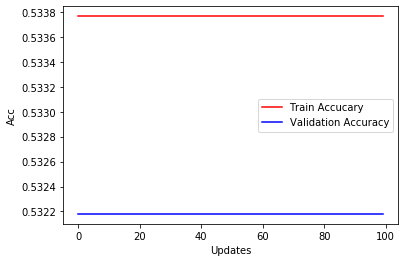

In [35]:

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 100
num_train = X_train.shape[0]
num_batches_train = num_train // batch_size
num_valid = X_valid.shape[0]
num_batches_valid = num_valid // batch_size

input_train = X_train.to_numpy()
input_valid = X_valid.to_numpy()
input_test = X_test.to_numpy()
target_train = y_train.ravel()
target_valid = y_valid.ravel()
target_test = y_test.ravel()


# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    net.train()
    for i in range(batch_size):
        slce = get_slice(i, batch_size)
        input_batch = Variable(torch.from_numpy(input_train[slce]).float())
        output_batch = net(input_batch)
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(target_train[slce]).long())
        batch_loss = criterion(output_batch, target_batch)
        
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        input_batch = Variable(torch.from_numpy(input_train[slce]).float())
        
        output_batch = net(input_batch)
        preds = torch.max(output_batch, 1)[1]
        
        train_targs += list(target_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        input_batch = Variable(torch.from_numpy(input_valid[slce]).float())
        
        output_batch = net(input_batch)
        preds = torch.max(output_batch, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(target_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 10 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

plt.savefig("nn-fit.png")